# Pluripotency Progress Analysis

Simple analysis which sees how close the different samples are to H1-hESC/Fibroblasts. This is similar to 20200124_H1_Progress except at single-cell instead of cluster level.

In [ ]:
library(ggrepel)
library(reshape2)
require(stringr)
library(SnapATAC)
library(GenomicRanges)
library(GenomicFeatures)
library(ggplot2)
library(DESeq2)
library(scales)

In [2]:
DAYS = c()
FILE_PREFIX = "/srv/scratch/surag/scATAC-reprog/snap"

file.list = c()
barcode.file.list = c()

for (i in seq(0, 14, 2)) {
    DAYS = c(DAYS, sprintf("D%d", i))
    file.list = c(file.list, sprintf("%s/D%d.snap", FILE_PREFIX, i))
}
DAYS
file.list

[1] "D0"  "D2"  "D4"  "D6"  "D8"  "D10" "D12" "D14"

[1] "/srv/scratch/surag/scATAC-reprog/snap/D0.snap" 
[2] "/srv/scratch/surag/scATAC-reprog/snap/D2.snap" 
[3] "/srv/scratch/surag/scATAC-reprog/snap/D4.snap" 
[4] "/srv/scratch/surag/scATAC-reprog/snap/D6.snap" 
[5] "/srv/scratch/surag/scATAC-reprog/snap/D8.snap" 
[6] "/srv/scratch/surag/scATAC-reprog/snap/D10.snap"
[7] "/srv/scratch/surag/scATAC-reprog/snap/D12.snap"
[8] "/srv/scratch/surag/scATAC-reprog/snap/D14.snap"

In [3]:
x.sp.ls = lapply(seq(file.list), function(i) {
    x.sp = createSnap(file = file.list[i],                      
                     sample = DAYS[i])
    x.sp
})

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...



In [4]:
# Metadata file from previous run
metaData = read.table("../20200122_snapATAC/snapATAC_sessions/20200125_n76770/metadata.tsv", header = T)
metaData$sample_barcode = paste(as.character(metaData$sample), as.character(metaData$barcode), sep='_')
metaData = metaData[order(metaData$sample_barcode), ]
head(metaData, 2)

,barcode,cluster,umap1,umap2,barcode.1,TN,UM,PP,UQ,CM,landmark,cluster.1,sample,sample_barcode
,<fct>,<int>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<chr>
1206,AAACAACGACGATTAC,6,2.515876,8.252824,AAACAACGACGATTAC,42629,38455,38381,33575,51,0,6,D0,D0_AAACAACGACGATTAC
1207,AAACAACGACTCACGG,6,2.355841,7.403916,AAACAACGACTCACGG,4424,4009,3998,3694,4,0,6,D0,D0_AAACAACGACTCACGG


In [5]:
# Filter cells 
x.sp.list = lapply(seq(x.sp.ls), function(i){
  x.sp = x.sp.ls[[i]];
  x.sp  = x.sp[x.sp@barcode %in% metaData[as.character(metaData$sample)==DAYS[i], "barcode"],];
})
names(x.sp.list) = DAYS;

In [6]:
x.sp.list

$D0
number of barcodes: 11133
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D2
number of barcodes: 9724
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D4
number of barcodes: 8726
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D6
number of barcodes: 10566
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D8
number of barcodes: 9895
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D10
number of barcodes: 4105
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D12
number of barcodes: 6334
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D14
number of barcodes: 16287
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0


In [7]:
# Using Peaks Matrix
x.sp.list = lapply(seq(x.sp.list), function(i) {
    x.sp = addPmatToSnap(x.sp.list[[i]], num.cores=5)
    x.sp
})

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...



In [8]:
# merge timepoints
x.sp = Reduce(snapRbind, x.sp.list);

Warning message:
“'rBind' is deprecated.
 Since R version 3.2.0, base's rbind() should work fine with S4 objects”


In [9]:
x.sp

number of barcodes: 76770
number of bins: 0
number of genes: 0
number of peaks: 467339
number of motifs: 0

In [10]:
dim(x.sp@pmat)

[1]  76770 467339

In [11]:
rm(x.sp.list); # free memory
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,10651395,568.9,16227038,866.7,12513989,668.4
Vcells,1073155436,8187.6,3802464954,29010.6,3019984561,23040.7


In [12]:
x.sp = makeBinary(x.sp, mat="pmat");

In [13]:
# order by sample_barcode
x.sp = x.sp[order(paste(x.sp@sample, x.sp@barcode, sep='_')), ]

In [14]:
x.sp@cluster = factor(metaData$cluster)
slot(x.sp, "umap") = as.matrix(metaData[, c("umap1", "umap2")])

number of barcodes: 76770
number of bins: 0
number of genes: 0
number of peaks: 436310
number of motifs: 0

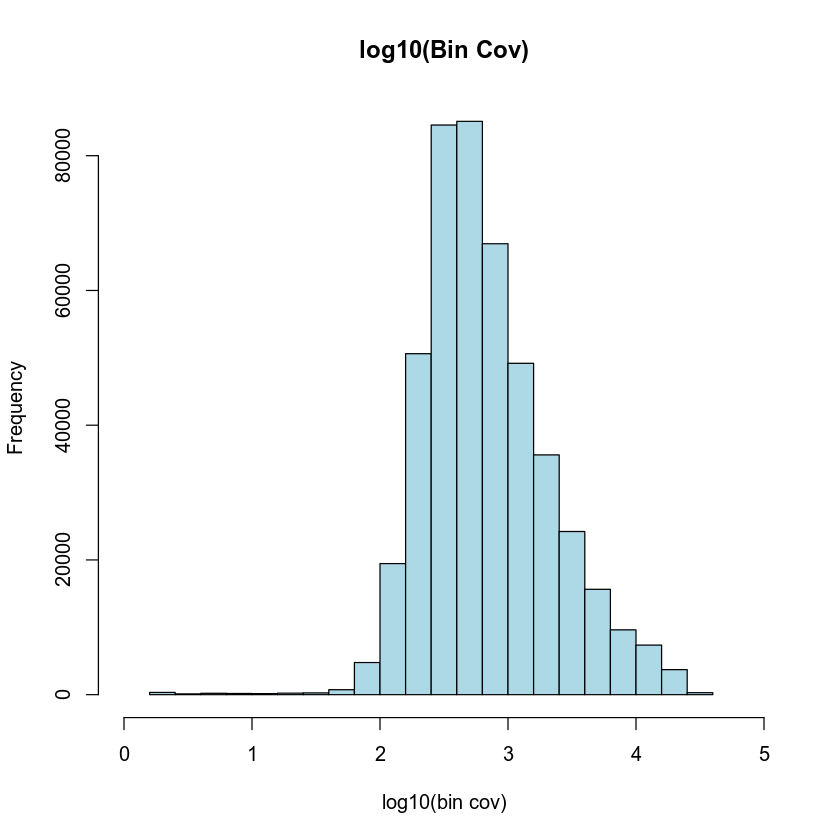

In [15]:
# remove all 0 bins and least variable ones
bin.cov = log10(Matrix::colSums(x.sp@pmat)+1);
hist(
  bin.cov[bin.cov > 0], 
  xlab="log10(bin cov)", 
  main="log10(Bin Cov)", 
  col="lightblue", 
  xlim=c(0, 5)
);
bin.cutoff = quantile(bin.cov[bin.cov > 0], 0.95);
idy = which(bin.cov <= bin.cutoff & bin.cov > 0);
x.sp = x.sp[, idy, mat="pmat"];
x.sp

## Load Reference Data

In [16]:
# H1
h1_atac_overlap_intersect_peaks <- read.csv("./data/H1.hESC.atac.overlap.bulk.cluster.overlap.intersect.txt",sep="\t")
rownames(h1_atac_overlap_intersect_peaks)=paste(h1_atac_overlap_intersect_peaks$chrom,h1_atac_overlap_intersect_peaks$start,h1_atac_overlap_intersect_peaks$end,sep='\t')
h1_atac_overlap_intersect_peaks$chrom = NULL
h1_atac_overlap_intersect_peaks$start = NULL
h1_atac_overlap_intersect_peaks$end = NULL
tail(head(h1_atac_overlap_intersect_peaks, 10), 2)

# binarize 
h1_atac_overlap_intersect_peaks[,"count"] = ifelse(h1_atac_overlap_intersect_peaks[,"count"] > 0, 1, 0)
tail(head(h1_atac_overlap_intersect_peaks, 10), 2)

,count
,<int>
chr1 267866 268149,0
chr1 502571 502779,0


,count
,<dbl>
chr1 267866 268149,0
chr1 502571 502779,0


In [17]:
# D0 (fibroblast) peaks
D0_atac_overlap_intersect_peaks <- read.csv("./data/D0.overlap.bulk.cluster.overlap.intersect.txt",sep="\t")
rownames(D0_atac_overlap_intersect_peaks)=paste(D0_atac_overlap_intersect_peaks$chrom,D0_atac_overlap_intersect_peaks$start,D0_atac_overlap_intersect_peaks$end,sep='\t')
D0_atac_overlap_intersect_peaks$chrom = NULL
D0_atac_overlap_intersect_peaks$start = NULL
D0_atac_overlap_intersect_peaks$end = NULL
tail(head(D0_atac_overlap_intersect_peaks, 10), 2)

# binarize 
D0_atac_overlap_intersect_peaks[,"count"] = ifelse(D0_atac_overlap_intersect_peaks[,"count"] > 0, 1, 0)
tail(head(D0_atac_overlap_intersect_peaks, 10), 2)

,count
,<int>
chr1 267866 268149,0
chr1 502571 502779,0


,count
,<dbl>
chr1 267866 268149,0
chr1 502571 502779,0


## Compute Jaccard Distances + Normalize

In [18]:
calJaccard <- function(X_i, X_j){
    A = Matrix::tcrossprod(X_i, X_j);
    bi = Matrix::rowSums(X_i);
    bj = Matrix::rowSums(X_j);
    jmat = as.matrix(A / (replicate(ncol(A), bi) + t(replicate(nrow(A), bj)) - A));
    rm(A);
    rm(bi);
    rm(bj);
    gc();
    return(jmat);
}

In [19]:
# fails with 1 row, use at least 2
x = matrix(0, nrow=2, ncol=dim(x.sp@pmat)[2])
x[1, ] = unlist(h1_atac_overlap_intersect_peaks)[idy]
x[2, ] = unlist(D0_atac_overlap_intersect_peaks)[idy]

In [20]:
j = calJaccard(x.sp@pmat, x)

In [21]:
p1 = Matrix::rowSums(x.sp@pmat)/dim(h1_atac_overlap_intersect_peaks)[1]
p2 = sum(x[1,])/dim(x)[2]

In [22]:
p2

[1] 0.2020582

In [23]:
expected = 1/((1/p1) + (1/p2) - 1)

In [24]:
data = data.frame(x=c(expected), y=c(j[,1]))
model = lm(y ~ 0 + x + I(x^2), data)
preds = predict(model, data.frame(x=c(expected)))

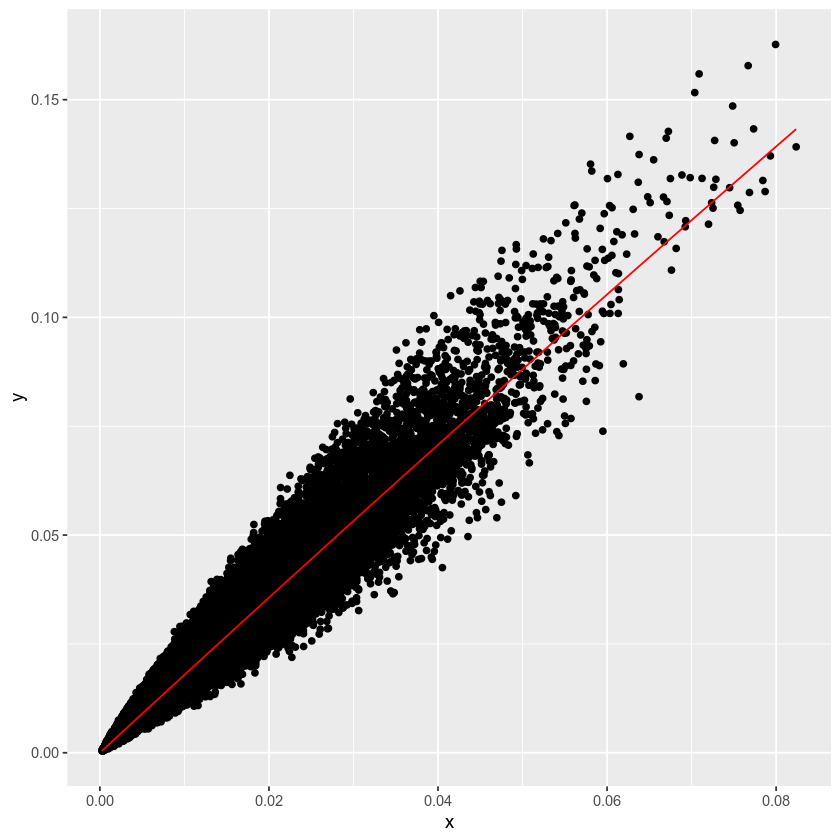

In [25]:
ggplot(data.frame(x=c(expected), y=c(j[,1]), p=preds)) +
geom_point(aes(x=x,y=y)) +
geom_line(aes(x=x, y=p), color="red")

In [26]:
normalized = j[,1]/preds

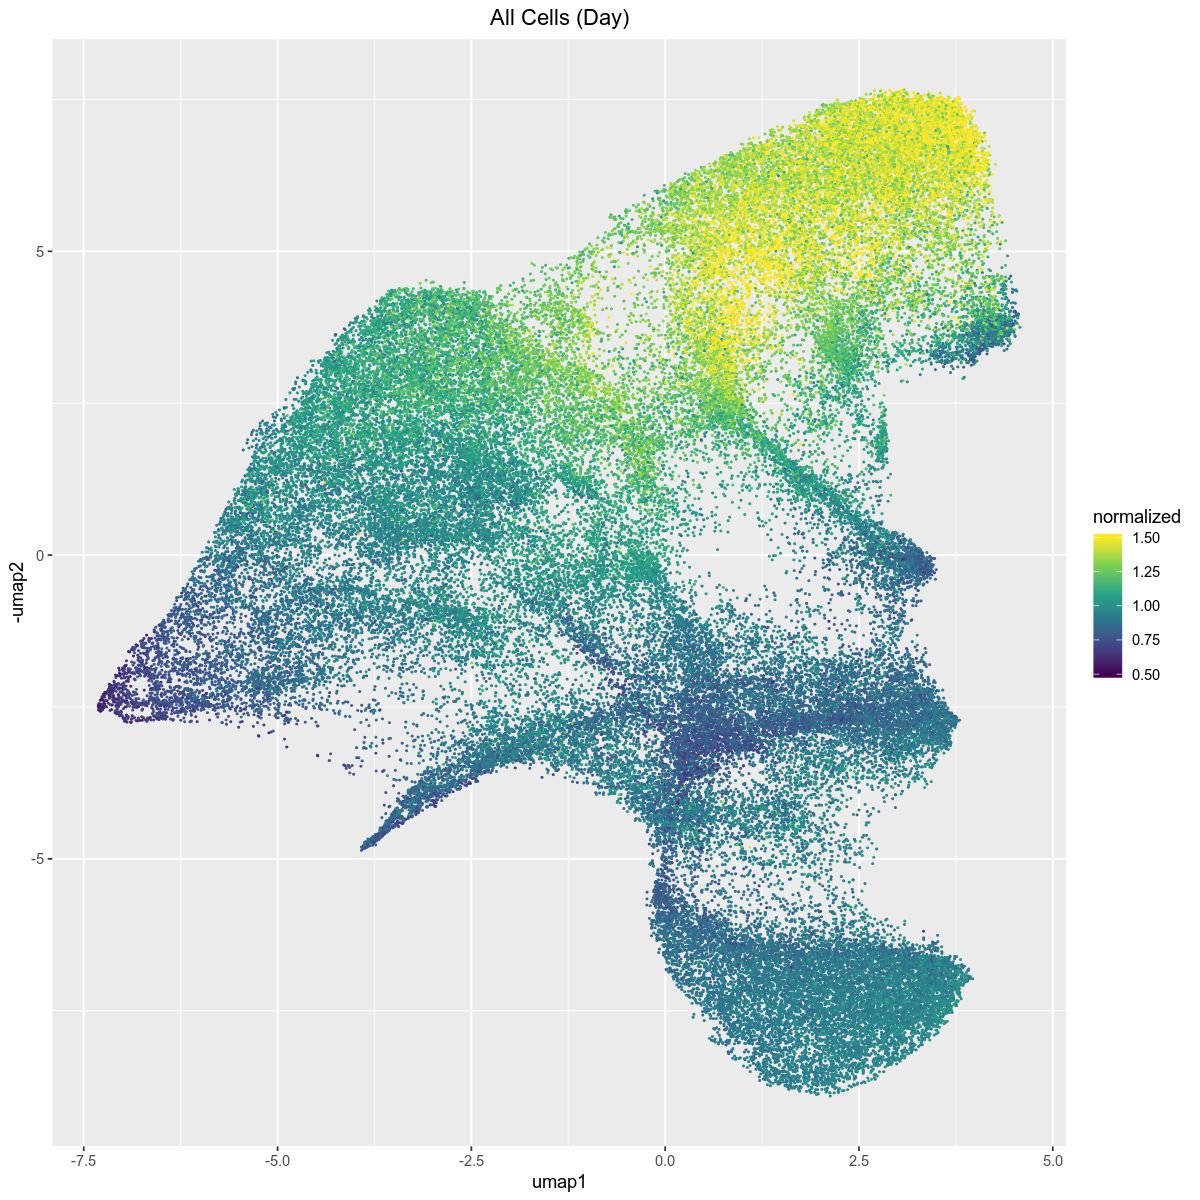

In [27]:
options(repr.plot.width = 10, repr.plot.height = 10)

df = data.frame(x.sp@umap, x.sp@sample, normalized)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=0.2, alpha=1, aes(x=umap1 , y=-umap2, col=normalized)) +
scale_color_viridis_c(limit=c(0.5,1.5), oob = squish) +
# scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) 
# guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 
# ggsave(sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_wD28_n%d_UMAP_day.pdf", 
#                format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1]))

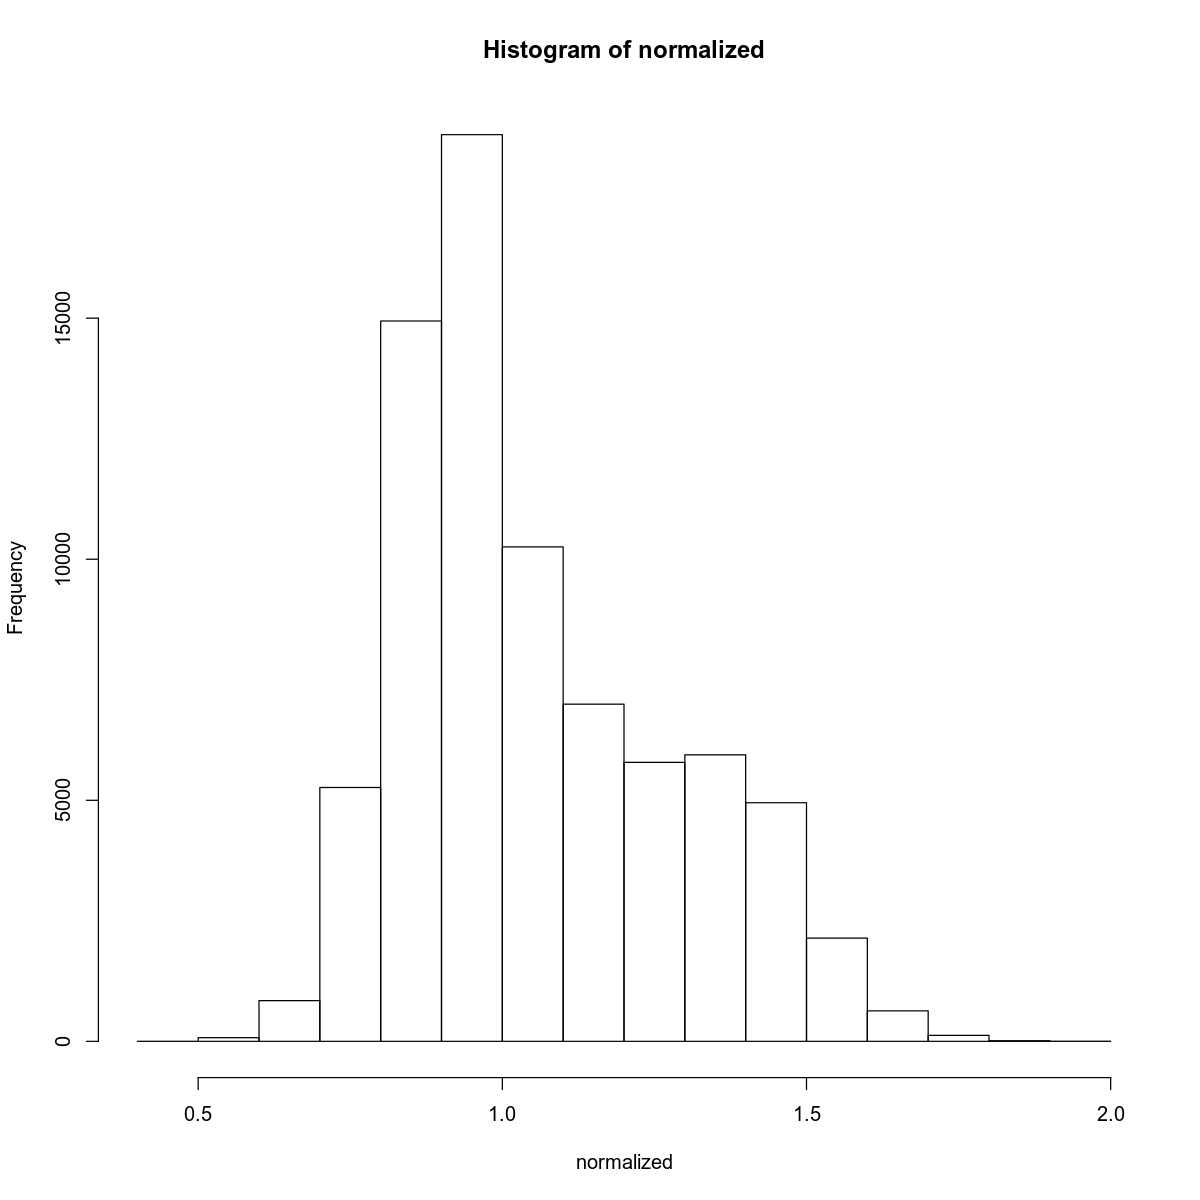

In [28]:
hist(normalized)

### Same for Fibroblast

Re-do this instead by taking IDR peaks similar to H1. Otherwise the predicted values are coming out negative.

In [29]:
# prob for fibroblast
p3 = sum(x[2,])/dim(x)[2]
p3

[1] 0.3197933

In [30]:
expected = 1/((1/p1) + (1/p3) - 1)

In [31]:
data = data.frame(x=c(expected), y=c(j[,2]))
model = lm(y ~ x + I(x^2), data)
preds = predict(model, data.frame(x=c(expected)))

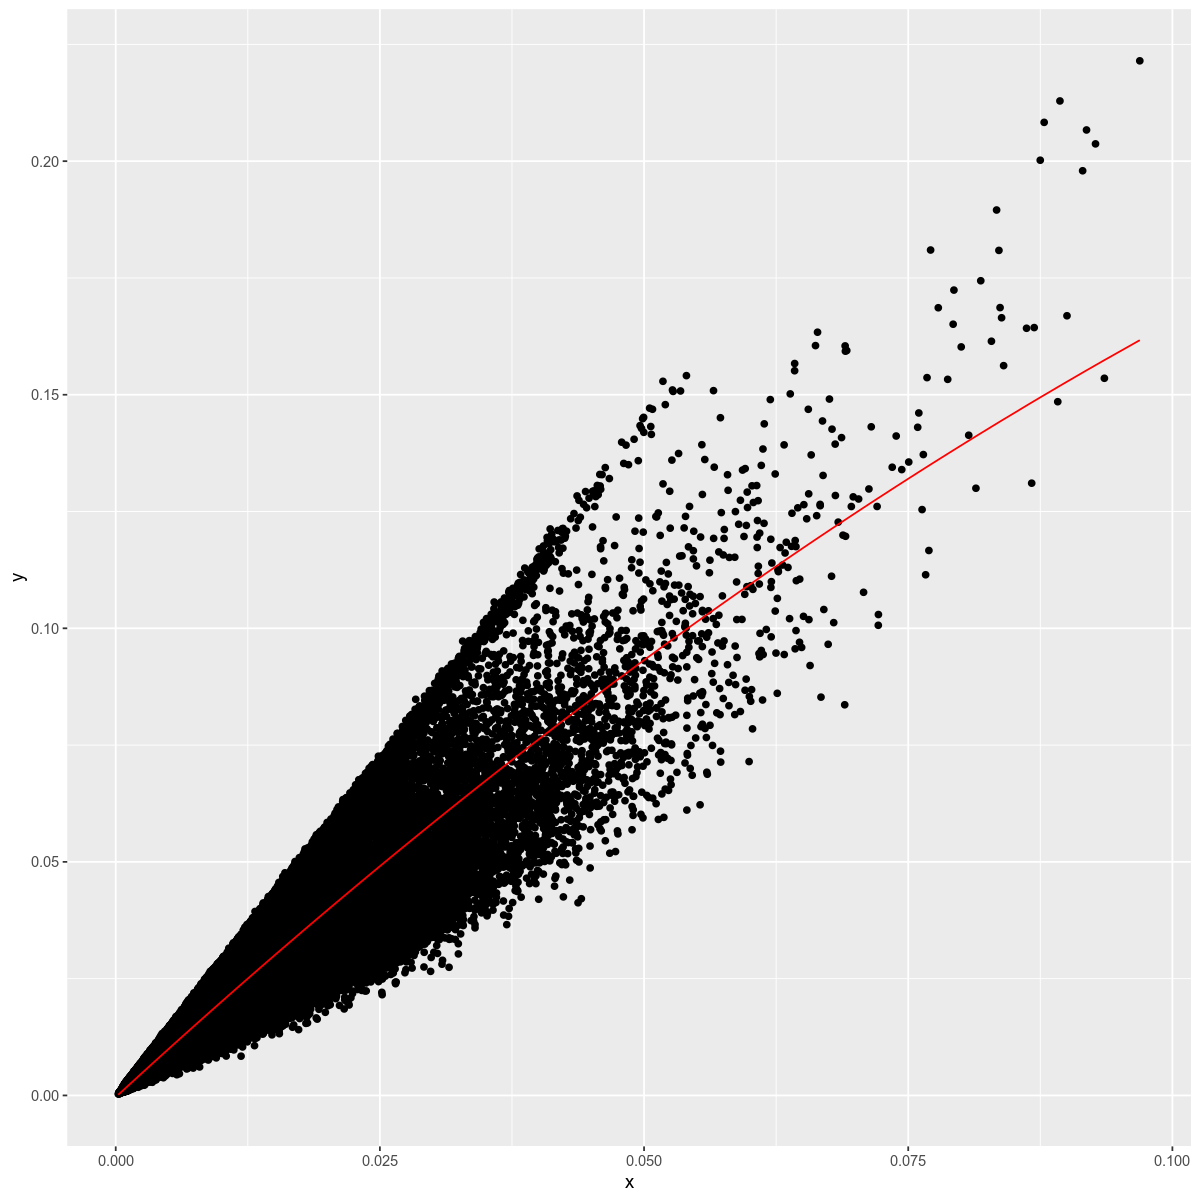

In [32]:
ggplot(data.frame(x=c(expected), y=c(j[,2]), p=preds)) +
geom_point(aes(x=x,y=y)) +
geom_line(aes(x=x, y=p), color="red")

In [33]:
normalized = j[,2]/preds

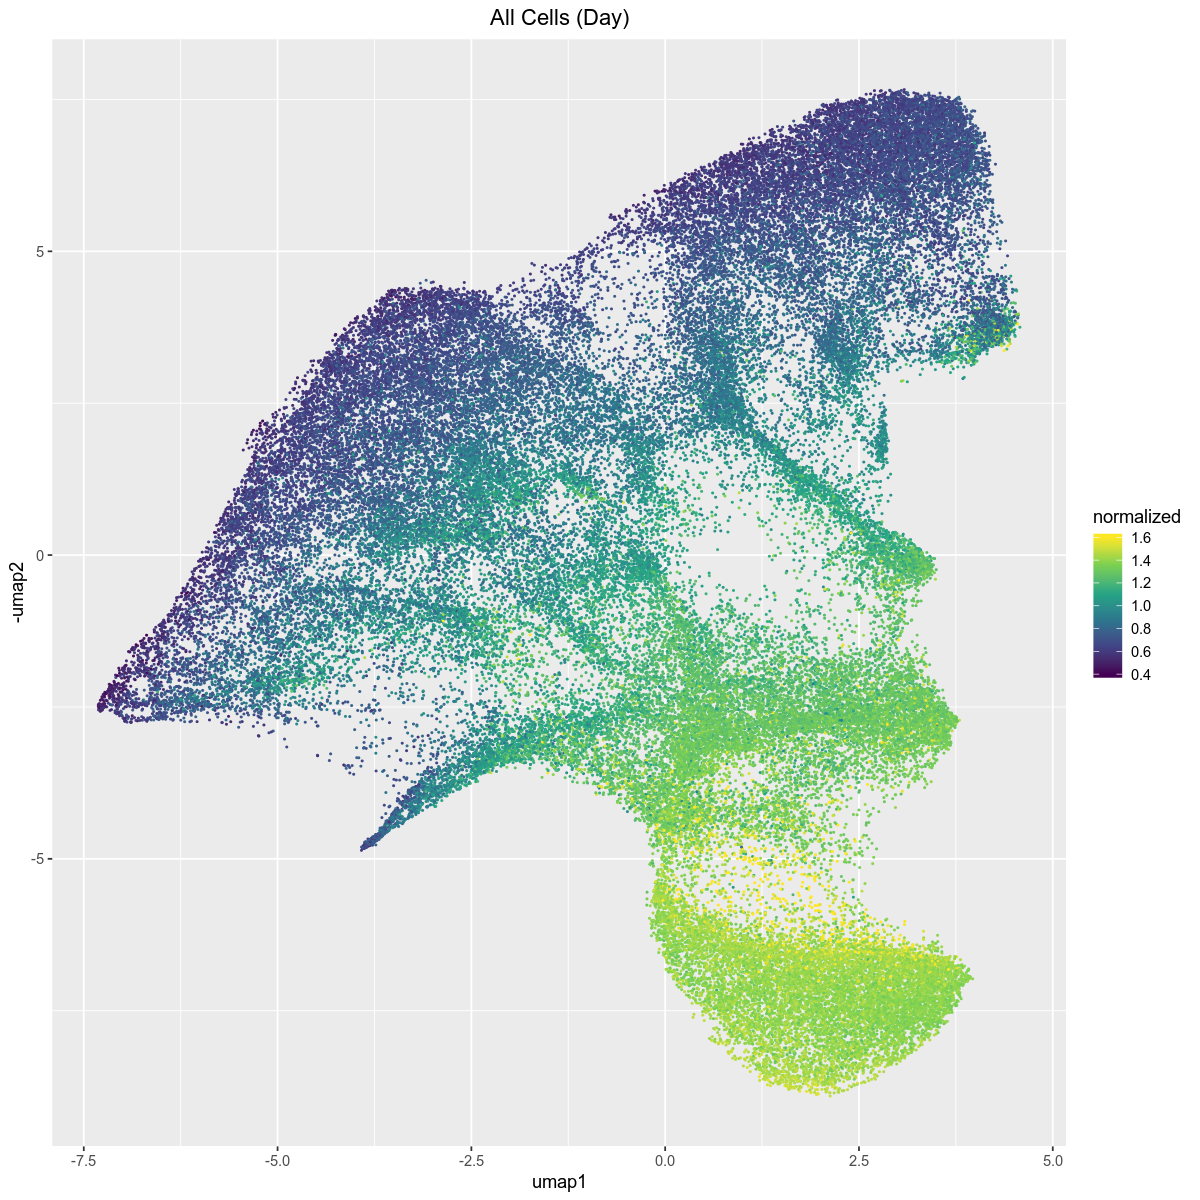

In [34]:
options(repr.plot.width = 10, repr.plot.height = 10)

df = data.frame(x.sp@umap, x.sp@sample, normalized)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=0.2, alpha=1, aes(x=umap1 , y=-umap2, col=normalized)) +
scale_color_viridis_c(limit=c(0.4,1.6), oob = squish) +
# scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) 
# guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 
# ggsave(sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_wD28_n%d_UMAP_day.pdf", 
#                format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1]))

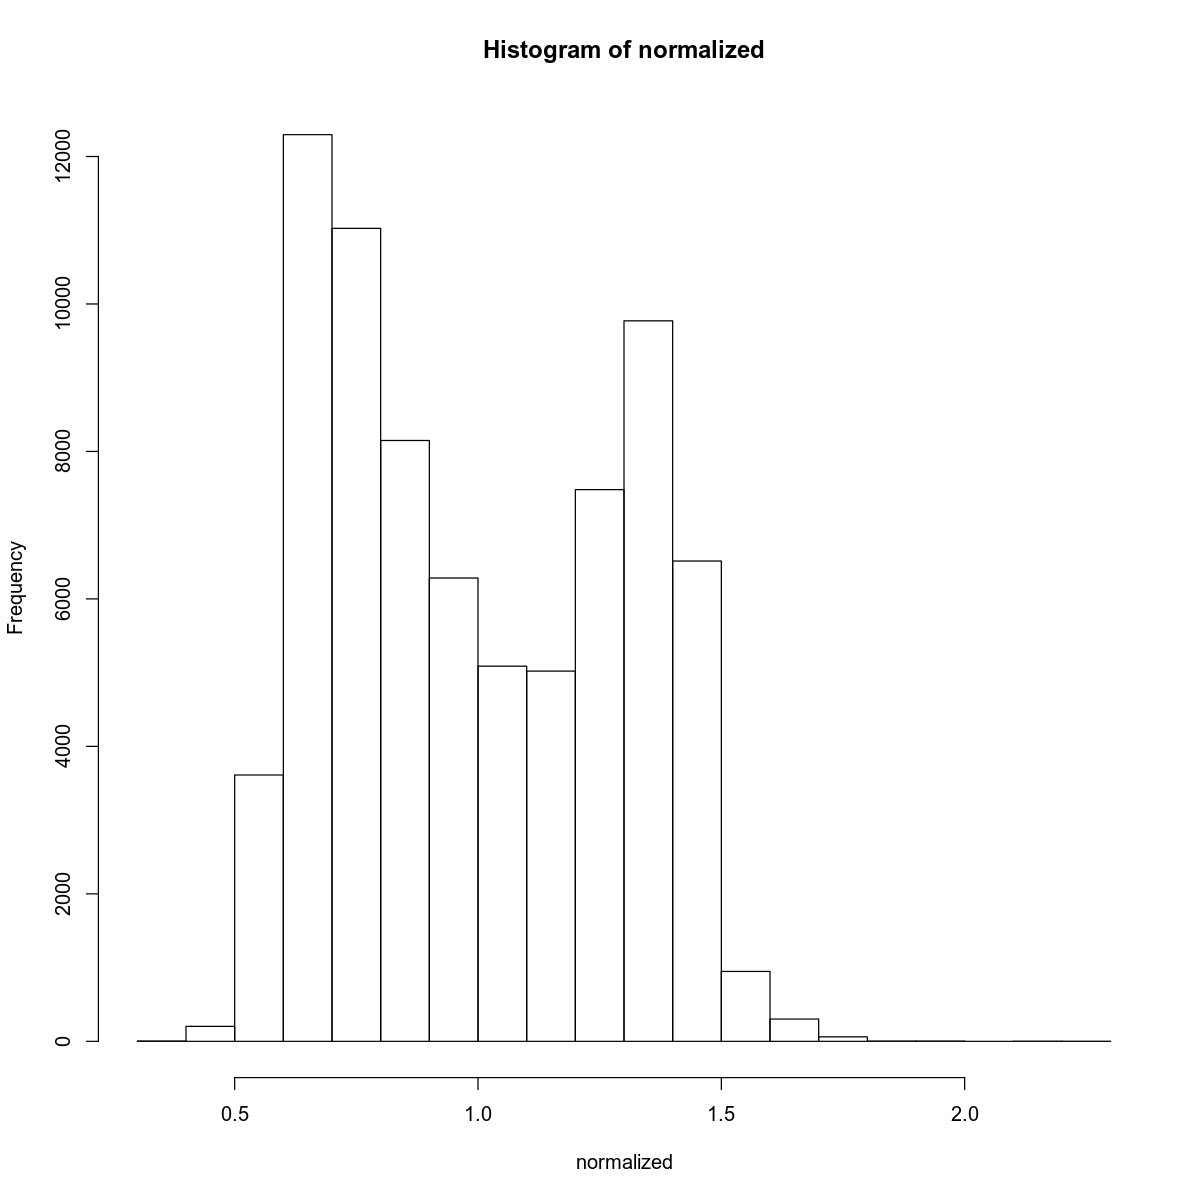

In [35]:
hist(normalized)